# Image Processing with a CNN - Assignment 7

This assignment follows the same structure as Assignment 6. We will employ at least a 2x2 completely crossed experimental design. We will again use a simple training-and-test regimen. The factors in the design may include numbers of layers and/or nodes within layers, types of layers (convolutional or pooling), and/or other hyperparameters. You will utilize convolutional neural networks (CNNs) within Python TensorFlow. 

This week, you will compete in the Dogs vs. Cats kernels Edition Kaggle.com competition, https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition (Links to an external site.). .  (Links to an external site.)Specifically, you will build models using the training set to forecast the test set. The images are in .jpg format, so you will need to research how to handle that.  You are required to submit no fewer than four models for evaluation by Kaggle.com, and you must provide your Kaggle.com scores and user ID for validation. 

Management Problem
Assume that we are providing advice to a website provider who is looking for tools to automatically label images provided by end users. As we look across the factors in the study, making recommendations to management about image classification, we are most concerned about achieving the highest possible accuracy in image classification. That is, we should be willing to sacrifice training time for model accuracy. What type of machine learning model works best? If it is a convolutional neural network, what type of network should we use? Part of this recommendation may concern information about the initial images themselves (input data for the classification task). What types of images work best?

## EDA

In [1]:
#https://www.kaggle.com/varnez/dogs-vs-cats-kernel-simple-keras-cnn

dataset_subset = False # Train with only a subset of the data for quick tests
data_subset_size = 2000 # Subset size (for each class)
color = True # Keep the color dimension or else load the data in greyscale
data_generation = True # Perform data augmentation
assign_test_labels = False # Sets all test predictions to either 1 or 0
quick_training = False # Reduces the number of epochs to a 10%

early_stop_overfitting = True; 
# Stop the training if the model doesn't improve in order to prevent overfitting
learning_rate_smoothing = True; 
# Reduces the learning rate of the backpropagation during the fitting if the model isn't improving

In [2]:
#Regular CNNs hyperparameters
batch_size = 16
num_clases = 1
epochs = 100
conv_kernel_size = 3

# CNN fine tuning hyperparameters
default_dropout_rate = 0.2
regularizaion_weight = 0.001
learning_rate_reduction_factor = 0.5

# Data hyperparameters
img_width = 132
img_height = 132
validation_size = 0.2

if color:
    img_channels = 3
else:
    img_channels = 1
    
if quick_training:
    epochs = epochs * 0.1

In [3]:
import os # data fetching
import random # training set shuffling
import gc # garbage collector to clean memory
import cv2 # image preprocessing

In [4]:
train_dir = 'train'
test_dir = 'test'

train_imgs = ['train/{}'.format(filename) for filename in os.listdir(train_dir)]

random.shuffle(train_imgs)

test_imgs = ['test/{}'.format(test_img) for test_img in os.listdir(test_dir)]
# The ids gets processed as just the numbers in the filename as integers, without the extension
test_ids = list(map(lambda sub:int(''.join( [ele for ele in sub if ele.isnumeric()])), test_imgs)) 

In [5]:
import numpy as np # linear algebra
from sklearn.model_selection import train_test_split # train-validation splitter

In [6]:
 def preprocess_images(img_path_list):
    """
    Loads and preprocesses all the images whose paths included in img_path_list
    Return
        X: array of resized images
        y: array of labels
    """
    X = []
    y = []
    
    for img_path in img_path_list:
        if color:
            x = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
            x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
            # This last bit is to have the images coverted from the default BGR from cv2
            # to RGB to correctly visualize the dataset (it has no effect over the training)
        else:
            x = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            
        x = cv2.resize(x, (img_height, img_width))
        X.append(x)
        
        if 'dog' in img_path:
            y.append(1)          
        elif 'cat' in img_path:
            y.append(0)

    return X, y

In [7]:
X, y = preprocess_images(train_imgs)

del train_imgs
gc.collect()

# Validation set splitting
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=validation_size)

del X
del y
gc.collect()

X_train = np.array(X_train)
X_val = np.array(X_val)
y_train = np.array(y_train)
y_val = np.array(y_val)

train_size = X_train.shape[0]
val_size = X_val.shape[0]

print("Train and validation shapes")
print("X_train: " + str(X_train.shape))
print("X_val: " + str(X_val.shape))
print("y_train: " + str(y_train.shape))
print("y_val: " + str(y_val.shape))

Train and validation shapes
X_train: (20000, 132, 132, 3)
X_val: (5000, 132, 132, 3)
y_train: (20000,)
y_val: (5000,)


In [8]:
X_test, _ = preprocess_images(test_imgs)

X_test = np.array(X_test).astype('float32')

# If data generation is beign used, as it will transform train images to float (and, so, values 
# from 0 to 1), test dataset should be adapted to what our model is going to learn to treat.
if data_generation:
    X_test /= 255

# Memory liberation tasks
del test_imgs
gc.collect
    
print("Test dataset shape: ")
print(X_test.shape)

Test dataset shape: 
(12500, 132, 132, 3)


In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
# Documentation: https://keras.io/preprocessing/image/

In [10]:
if data_generation:
    
    # Fourth dimension addition in case of its value being onesized
    if img_channels == 1:
        X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
        X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], X_val.shape[2], 1)
        
    data_augmentator = ImageDataGenerator(rescale=1./255, rotation_range=0.2, shear_range=0.1, zoom_range=0.2,
                                          width_shift_range=0.1, height_shift_range=0.1, fill_mode='reflect',horizontal_flip=True)
    data_augmentator.fit(X_train)
    data_generator = data_augmentator.flow(X_train, y_train, batch_size=batch_size)
    
    val_augmentator = ImageDataGenerator(rescale=1./255)
    val_generator = val_augmentator.flow(X_val, y_val, batch_size=batch_size)

    # Dimension restitution
    if img_channels == 1:
        X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
        X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], X_val.shape[2])

In [11]:
%matplotlib inline 

from matplotlib import pyplot as plt # data visualization

In [12]:
def plot_data(X, y, num_figures):
    """
    Prints the images stored in X, with their correspondent labels in y.
    num_figures images by row.
    """
    plt.figure(figsize=(30, 20))

    for i in range(num_figures):
        plt.subplot(2, num_figures, i+1)
        if color:
            plt.imshow(X[i])
        else:
            plt.imshow(X[i], cmap='gray')
        if y[i] >= 0.5:
            plt.title("Dog ("+ str(y[i]) + ")", fontsize=30)
        else:
            plt.title("Cat ("+ str(y[i]) + ")", fontsize=30)
            
    plt.tight_layout()
    plt.show()

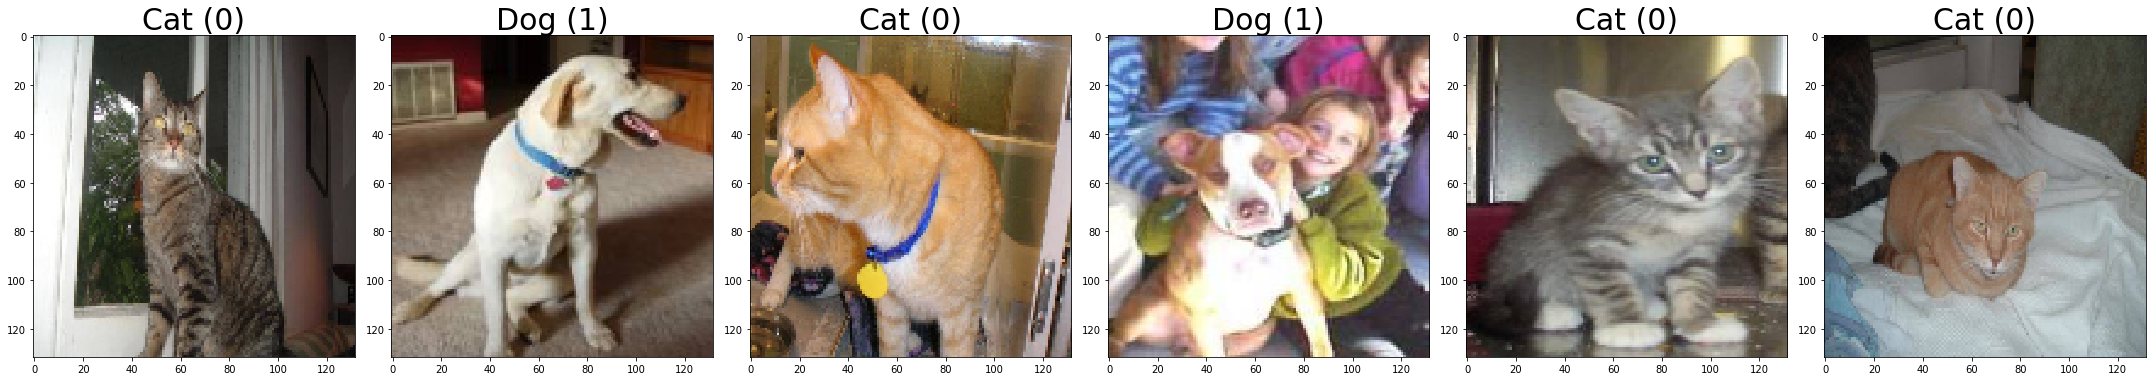

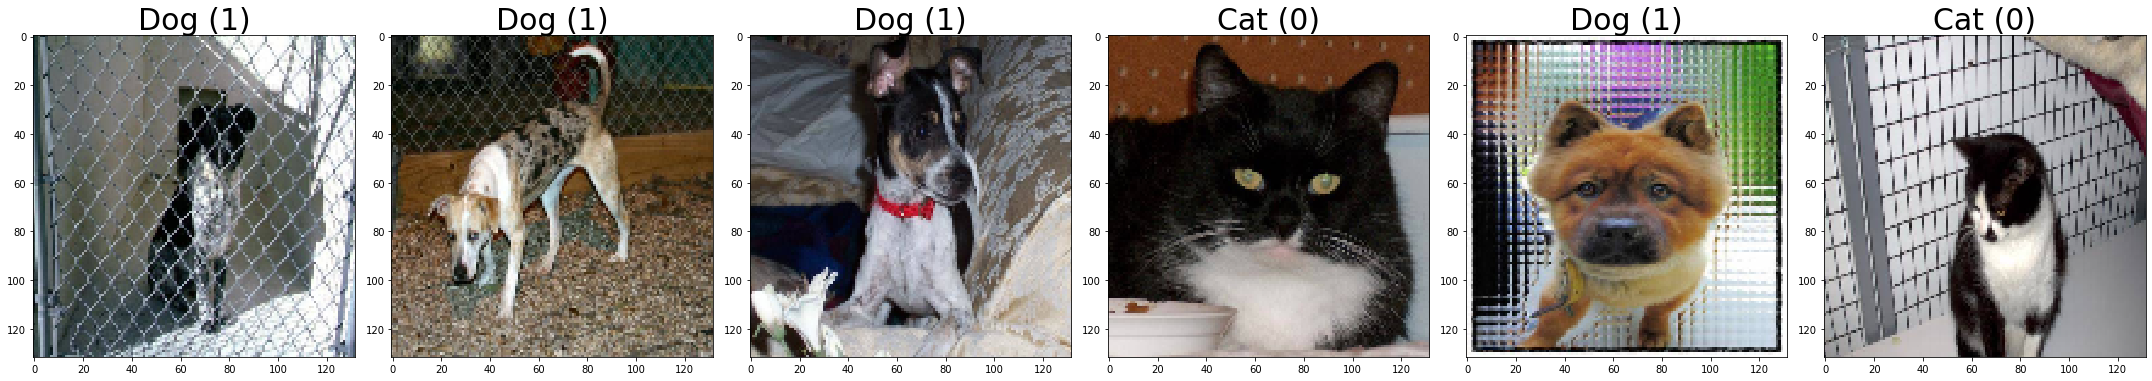

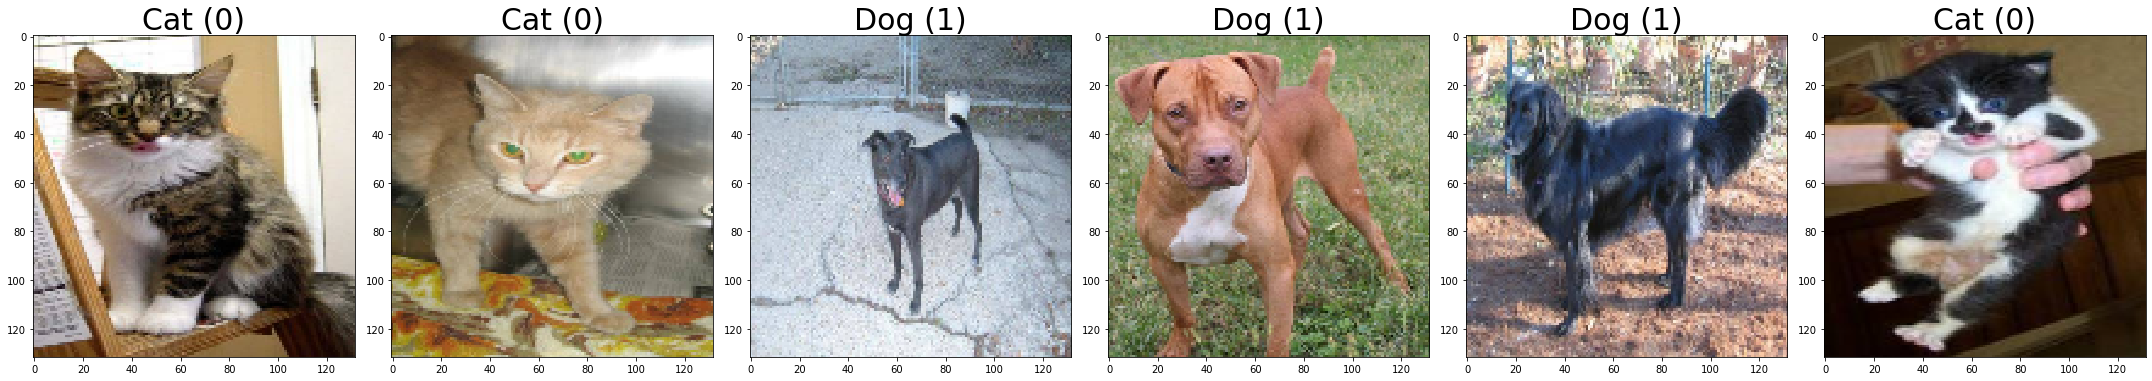

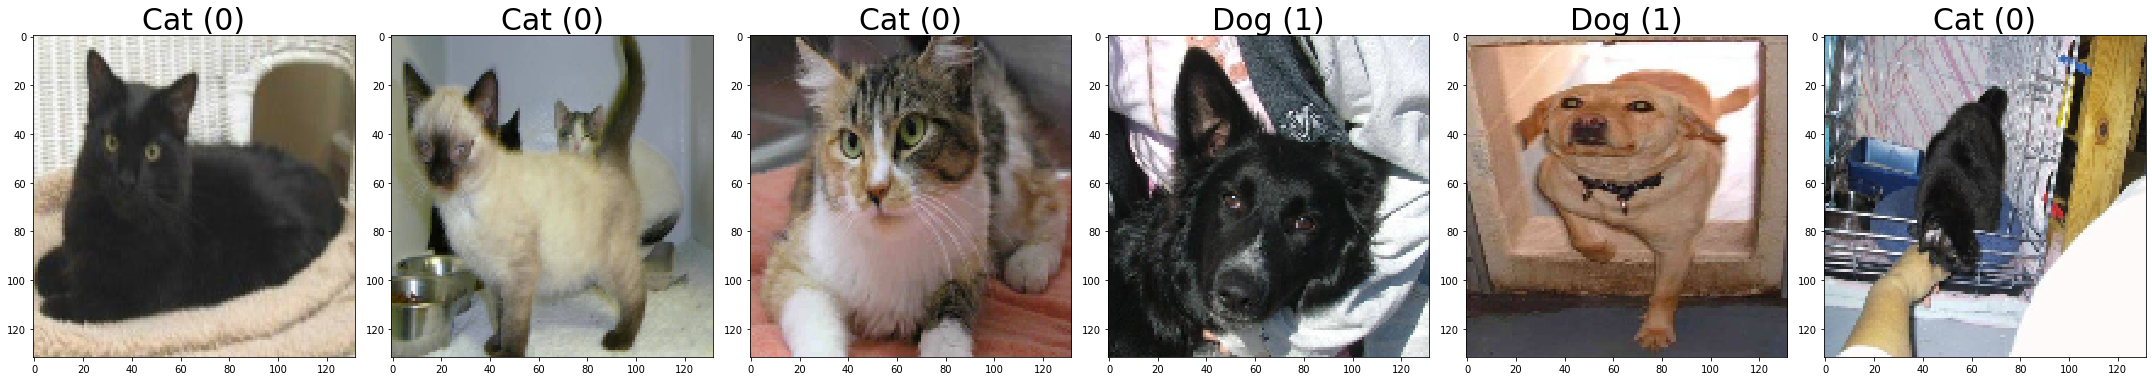

In [13]:
# Preprocess training dataset showcase with labels
for i in range(0, 24, 6): 
    plot_data(X_train[i:], y_train[i:], 6)

X_train_gen shape: (16, 132, 132, 3)
y_train_gen shape: (16,)


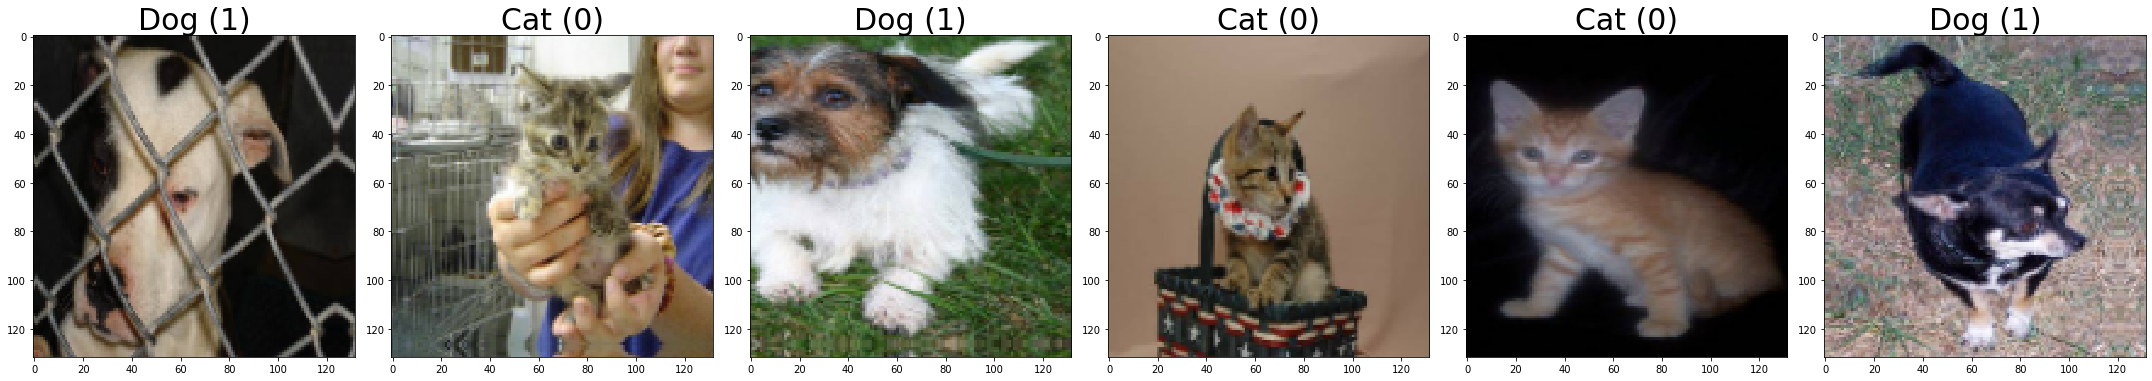

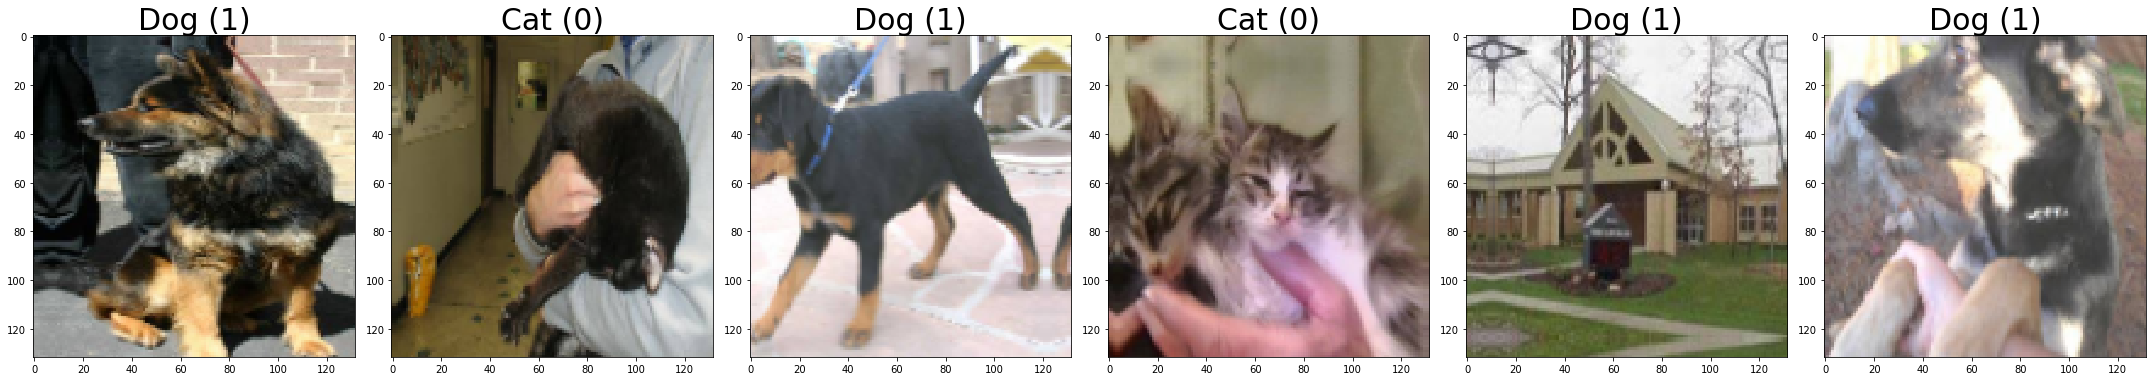

In [14]:
if data_generation:
    
    for X_train_gen, y_train_gen in data_generator:
        
        if img_channels == 1:
            X_train_gen = X_train_gen.reshape(X_train_gen.shape[0], X_train_gen.shape[1], X_train_gen.shape[2])
        
        print("X_train_gen shape: " + str(X_train_gen.shape))
        print("y_train_gen shape: " + str(y_train_gen.shape))
        
        for i in range(0, batch_size-6, 6):
            plot_data(X_train_gen[i:], y_train_gen[i:], 6)
            
        del X_train_gen
        del y_train_gen
        gc.collect()
        
        break

Interestingly, it appears that there are images in the training data that are neither cats or dogs, such as row 2 column 5.  The models would likely be improved if these images were removed but in the interest of time they will be left in.  From research on Kaggle there look to be around 50ish such images.  

## Model 1

Model 1 will consist of a CNN with batch normalization and dropout.  The parameters that will be tested are the number of nodes in the final layers (512 vs 1024) as well as the convolution kernel size (3 vs 4).  Model 1 has 1024 nodes with a convolution kernel size of 3. 

In [15]:
# Imports
from tensorflow.keras.models import Sequential # Documentation: https://keras.io/models/sequential/
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense # Documentation: https://keras.io/layers/core/, https://keras.io/layers/convolutional/
from tensorflow.keras.layers import Dropout, SpatialDropout2D, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop # Documentation: https://keras.io/optimizers/
from tensorflow.keras.regularizers import l2 # Documentation: https://keras.io/regularizers/

In [16]:
def add_regularization_layer(model, type, rate=default_dropout_rate):
    """
    Adds a regularization layer to the model based on the active control hiperparameters.
    It's open to multipple addition, although you probably want to add only one of them.
    
    'rate' parameter only affects dropout layers.
    """
    if type == "batch_normalization":
        model.add(BatchNormalization())
    if type == "spatial_dropout":
        model.add(SpatialDropout2D(rate)) 
    if type == "dropout":
        model.add(Dropout(rate))

In [17]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(conv_kernel_size, conv_kernel_size), activation='relu', input_shape=(img_width, img_height, img_channels))) # Strides are, by default, (1,1)
add_regularization_layer(model,"batch_normalization")
add_regularization_layer(model,"spatial_dropout", 0.25)
model.add(MaxPooling2D(pool_size=(2,2))) # Strides are, by default, of the same size of the pool size


model.add(Conv2D(64, kernel_size=(conv_kernel_size, conv_kernel_size), activation='relu'))
add_regularization_layer(model,"batch_normalization")
add_regularization_layer(model,"spatial_dropout", 0.25)
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128, kernel_size=(conv_kernel_size, conv_kernel_size), activation='relu'))
add_regularization_layer(model,"batch_normalization")
add_regularization_layer(model,"spatial_dropout", 0.25)
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(256, kernel_size=(conv_kernel_size, conv_kernel_size), activation='relu'))
add_regularization_layer(model,"batch_normalization")
add_regularization_layer(model,"spatial_dropout", 0.25)
model.add(Conv2D(256, kernel_size=(conv_kernel_size, conv_kernel_size), activation='relu'))
add_regularization_layer(model,"batch_normalization")
add_regularization_layer(model,"spatial_dropout", 0.25)
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten()) 

model.add(Dense(1024, activation='relu', kernel_regularizer=l2(regularizaion_weight)))
add_regularization_layer(model,"batch_normalization")
add_regularization_layer(model,"dropout", 0.5)
model.add(Dense(1024, activation='relu', kernel_regularizer=l2(regularizaion_weight)))
add_regularization_layer(model,"batch_normalization")
add_regularization_layer(model,"dropout", 0.5)
model.add(Dense(num_clases, activation='sigmoid', kernel_regularizer=l2(regularizaion_weight)))

In [18]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# Documentation: https://keras.io/callbacks/

In [19]:
# Stops the training in the case of validation score not improving
if early_stop_overfitting:
    early_stop = EarlyStopping(patience=5)
    
    if not learning_rate_smoothing:
        callbacks = [early_stop]

# Reduces the learning rate of the back propagation gradient descend in the case of validation score not improving
if learning_rate_smoothing:
    learning_rate_reduction = ReduceLROnPlateau(monitor="val_accuracy", patience=2, factor=learning_rate_reduction_factor, min_lr=0.00001, verbose=1)
    
    if not early_stop_overfitting:
        callbacks = [learning_rate_reduction]
    else:
        callbacks = [early_stop, learning_rate_reduction]

In [20]:
model.summary()

model.compile(loss='binary_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 130, 130, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 130, 130, 32)      128       
_________________________________________________________________
spatial_dropout2d (SpatialDr (None, 130, 130, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 65, 65, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 63, 63, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 63, 63, 64)        256       
_________________________________________________________________
spatial_dropout2d_1 (Spatial (None, 63, 63, 64)        0

In [21]:
from datetime import datetime
start=datetime.now()

if data_generation:
    
    history = model.fit_generator(data_generator, epochs=epochs, validation_data=val_generator, 
                                  steps_per_epoch=train_size//batch_size, validation_steps=val_size//batch_size, 
                                  callbacks=callbacks, verbose=2)

else:
    
    # Fourth dimension addition in case of its value being onesized
    if img_channels == 1:
        X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
        X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], X_val.shape[2], 1)
        history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val),
                        steps_per_epoch=train_size//batch_size, validation_steps=val_size//batch_size, 
                        callbacks=callbacks, verbose=2)

    # Dimension restitution
    if img_channels == 1:
        X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
        X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], X_val.shape[2])
        
end=datetime.now()
print(end-start)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1250 steps, validate for 312 steps
Epoch 1/100
1250/1250 - 51s - loss: 1.7196 - accuracy: 0.5414 - val_loss: 0.9009 - val_accuracy: 0.5723
Epoch 2/100
1250/1250 - 49s - loss: 0.9242 - accuracy: 0.5632 - val_loss: 0.9726 - val_accuracy: 0.5004
Epoch 3/100
1250/1250 - 48s - loss: 0.8926 - accuracy: 0.6104 - val_loss: 0.8814 - val_accuracy: 0.6422
Epoch 4/100
1250/1250 - 48s - loss: 0.8587 - accuracy: 0.6481 - val_loss: 0.8023 - val_accuracy: 0.6943
Epoch 5/100
1250/1250 - 48s - loss: 0.8177 - accuracy: 0.6776 - val_loss: 0.7659 - val_accuracy: 0.7147
Epoch 6/100
1250/1250 - 52s - loss: 0.7950 - accuracy: 0.7018 - val_loss: 0.7239 - val_accuracy: 0.7306
Epoch 7/100
1250/1250 - 52s - loss: 0.7522 - accuracy: 0.7262 - val_loss: 0.7001 - val_accuracy: 0.7734
Epoch 8/100
1250/1250 - 50s - loss: 0.7328 - accuracy: 0.7459 - val_loss: 0.6723 - val_accuracy: 0.77

In [22]:
metrics = list(history.history.keys())
loss_values = history.history[metrics[2]]
val_loss_values = history.history[metrics[0]]
acc_values = history.history[metrics[3]]
val_acc_values = history.history[metrics[1]]
print("Final validation loss function is", val_loss_values[-1])
print("Final validation accuracy is", val_acc_values[-1])

Final validation loss function is 0.26989667316377164
Final validation accuracy is 0.89905


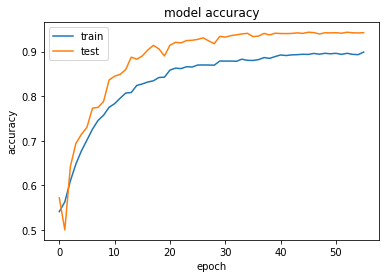

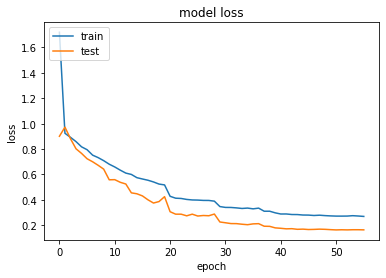

In [23]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [24]:
# Fourth dimension addition in case of its value being onesized
if img_channels == 1:
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
    
predictions = model.predict(X_test, verbose=0)

# Dimension restitution
if img_channels == 1:
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])

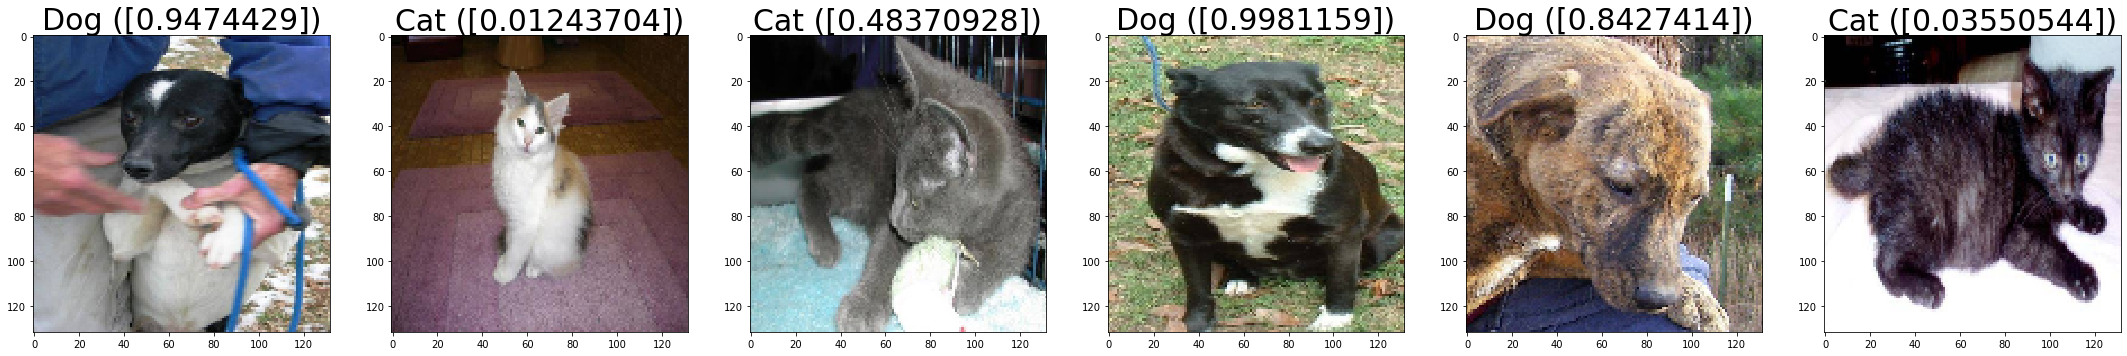

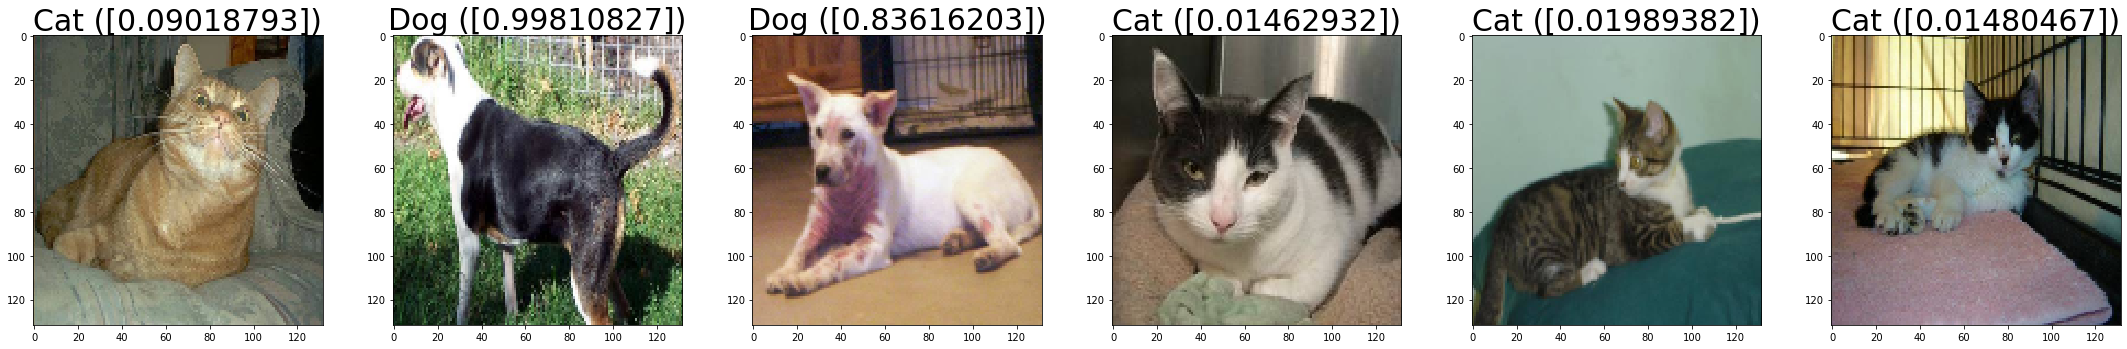

In [25]:
# Preprocess test dataset showcase with predictions
for i in range(0, 10, 6): 
    plot_data(X_test[i:], predictions[i:], 6)

In [26]:
import pandas as pd
# Predictions array must be reshaped into a single dimension array in order to create the dataframe
predictions = predictions.reshape(predictions.shape[0])

if assign_test_labels:
    labels = [1 if pred >= 0.5 else 0 for pred in predictions]
else:
    labels = predictions

submission = pd.DataFrame({'id':test_ids , 'label':labels})

# Let's check what we've got
submission.head()

id     label
0      1  0.947443
1     10  0.012437
2    100  0.483709
3   1000  0.998116
4  10000  0.842741

In [27]:
submission.to_csv("submission_1.csv", index=False)

## Model 2

Model 2 consists of 512 nodes and a convolution kernel size of 3.

In [28]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(conv_kernel_size, conv_kernel_size), activation='relu', input_shape=(img_width, img_height, img_channels))) # Strides are, by default, (1,1)
add_regularization_layer(model,"batch_normalization")
add_regularization_layer(model,"spatial_dropout", 0.25)
model.add(MaxPooling2D(pool_size=(2,2))) # Strides are, by default, of the same size of the pool size


model.add(Conv2D(64, kernel_size=(conv_kernel_size, conv_kernel_size), activation='relu'))
add_regularization_layer(model,"batch_normalization")
add_regularization_layer(model,"spatial_dropout", 0.25)
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128, kernel_size=(conv_kernel_size, conv_kernel_size), activation='relu'))
add_regularization_layer(model,"batch_normalization")
add_regularization_layer(model,"spatial_dropout", 0.25)
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(256, kernel_size=(conv_kernel_size, conv_kernel_size), activation='relu'))
add_regularization_layer(model,"batch_normalization")
add_regularization_layer(model,"spatial_dropout", 0.25)
model.add(Conv2D(256, kernel_size=(conv_kernel_size, conv_kernel_size), activation='relu'))
add_regularization_layer(model,"batch_normalization")
add_regularization_layer(model,"spatial_dropout", 0.25)
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten()) 

model.add(Dense(512, activation='relu', kernel_regularizer=l2(regularizaion_weight)))
add_regularization_layer(model,"batch_normalization")
add_regularization_layer(model,"dropout", 0.5)
model.add(Dense(512, activation='relu', kernel_regularizer=l2(regularizaion_weight)))
add_regularization_layer(model,"batch_normalization")
add_regularization_layer(model,"dropout", 0.5)
model.add(Dense(num_clases, activation='sigmoid', kernel_regularizer=l2(regularizaion_weight)))

# Stops the training in the case of validation score not improving
if early_stop_overfitting:
    early_stop = EarlyStopping(patience=5)
    
    if not learning_rate_smoothing:
        callbacks = [early_stop]

# Reduces the learning rate of the back propagation gradient descend in the case of validation score not improving
if learning_rate_smoothing:
    learning_rate_reduction = ReduceLROnPlateau(monitor="val_accuracy", patience=2, factor=learning_rate_reduction_factor, min_lr=0.00001, verbose=1)
    
    if not early_stop_overfitting:
        callbacks = [learning_rate_reduction]
    else:
        callbacks = [early_stop, learning_rate_reduction]
        
model.summary()

model.compile(loss='binary_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 130, 130, 32)      896       
_________________________________________________________________
batch_normalization_7 (Batch (None, 130, 130, 32)      128       
_________________________________________________________________
spatial_dropout2d_5 (Spatial (None, 130, 130, 32)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 65, 65, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 63, 63, 64)        18496     
_________________________________________________________________
batch_normalization_8 (Batch (None, 63, 63, 64)        256       
_________________________________________________________________
spatial_dropout2d_6 (Spatial (None, 63, 63, 64)       

In [29]:
from datetime import datetime
start=datetime.now()

if data_generation:
    
    history = model.fit_generator(data_generator, epochs=epochs, validation_data=val_generator, 
                                  steps_per_epoch=train_size//batch_size, validation_steps=val_size//batch_size, 
                                  callbacks=callbacks, verbose=2)

else:
    
    # Fourth dimension addition in case of its value being onesized
    if img_channels == 1:
        X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
        X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], X_val.shape[2], 1)
        history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val),
                        steps_per_epoch=train_size//batch_size, validation_steps=val_size//batch_size, 
                        callbacks=callbacks, verbose=2)

    # Dimension restitution
    if img_channels == 1:
        X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
        X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], X_val.shape[2])
        
end=datetime.now()
print(end-start)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1250 steps, validate for 312 steps
Epoch 1/100
1250/1250 - 49s - loss: 1.5027 - accuracy: 0.5674 - val_loss: 0.8435 - val_accuracy: 0.6486
Epoch 2/100
1250/1250 - 48s - loss: 0.8035 - accuracy: 0.6399 - val_loss: 0.7974 - val_accuracy: 0.6380
Epoch 3/100
1250/1250 - 47s - loss: 0.7671 - accuracy: 0.6722 - val_loss: 0.7140 - val_accuracy: 0.7083
Epoch 4/100
1250/1250 - 47s - loss: 0.7431 - accuracy: 0.6888 - val_loss: 0.6856 - val_accuracy: 0.7194
Epoch 5/100
1250/1250 - 47s - loss: 0.7204 - accuracy: 0.7078 - val_loss: 0.7179 - val_accuracy: 0.7171
Epoch 6/100
1250/1250 - 48s - loss: 0.6930 - accuracy: 0.7363 - val_loss: 0.6359 - val_accuracy: 0.7584
Epoch 7/100
1250/1250 - 47s - loss: 0.6777 - accuracy: 0.7457 - val_loss: 0.6031 - val_accuracy: 0.7977
Epoch 8/100
1250/1250 - 48s - loss: 0.6510 - accuracy: 0.7638 - val_loss: 0.6021 - val_accuracy: 0.7923
Epoch 9/100
1250/1250 - 49s - loss: 0.6252 - accuracy: 0.7796 - val_loss:

0:56:29.753816


In [30]:
metrics = list(history.history.keys())
loss_values = history.history[metrics[2]]
val_loss_values = history.history[metrics[0]]
acc_values = history.history[metrics[3]]
val_acc_values = history.history[metrics[1]]
print("Final validation loss function is", val_loss_values[-1])
print("Final validation accuracy is", val_acc_values[-1])

Final validation loss function is 0.27537003154456613
Final validation accuracy is 0.8967


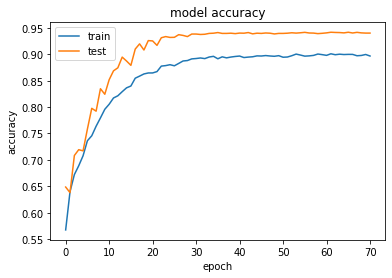

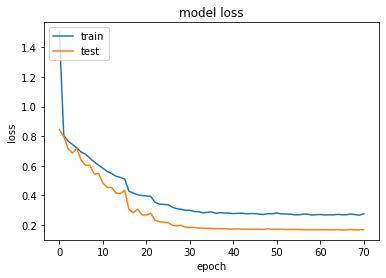

In [31]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [32]:
# Fourth dimension addition in case of its value being onesized
if img_channels == 1:
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
    
predictions = model.predict(X_test, verbose=0)

# Dimension restitution
if img_channels == 1:
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])

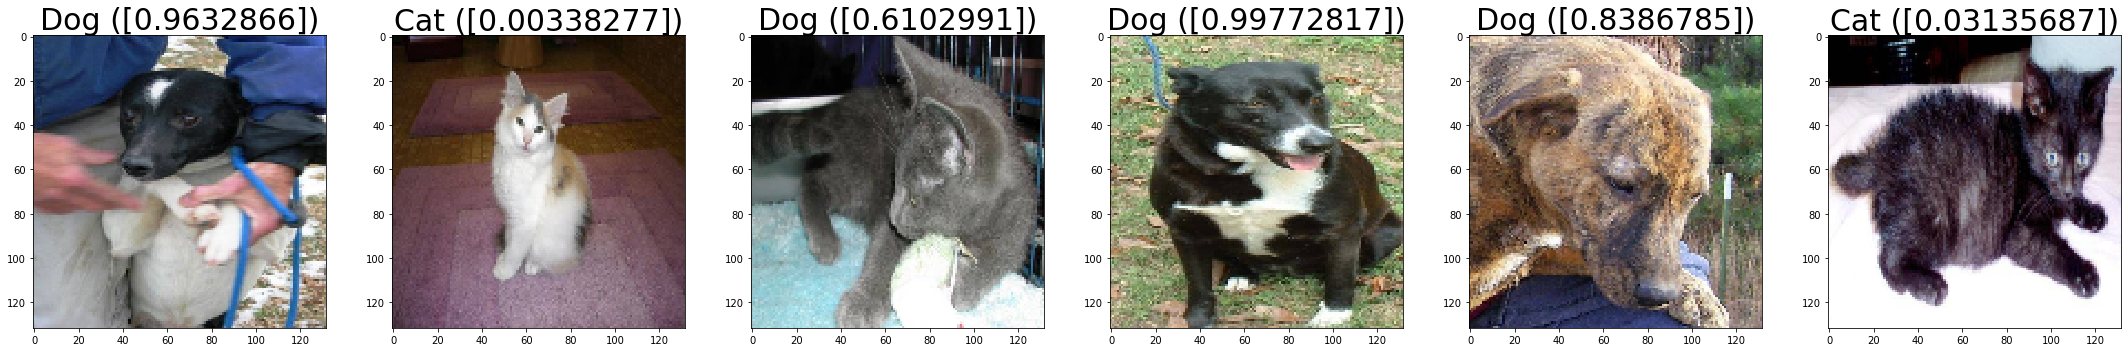

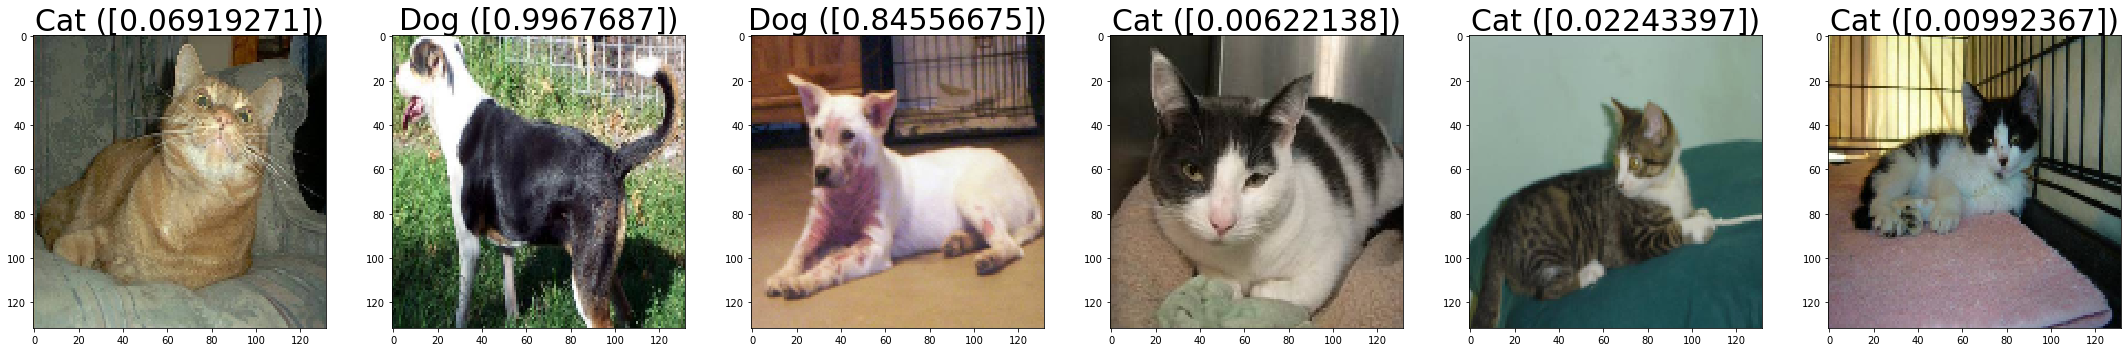

In [33]:
# Preprocess test dataset showcase with predictions
for i in range(0, 10, 6): 
    plot_data(X_test[i:], predictions[i:], 6)

In [34]:
import pandas as pd
# Predictions array must be reshaped into a single dimension array in order to create the dataframe
predictions = predictions.reshape(predictions.shape[0])

if assign_test_labels:
    labels = [1 if pred >= 0.5 else 0 for pred in predictions]
else:
    labels = predictions

submission = pd.DataFrame({'id':test_ids , 'label':labels})
submission.to_csv("submission_2.csv", index=False)
# Let's check what we've got
submission.head()

id     label
0      1  0.963287
1     10  0.003383
2    100  0.610299
3   1000  0.997728
4  10000  0.838678

## Model 3

Model 3 consists of 1024 nodes and a convolution kernel size of 4.

In [35]:
conv_kernel_size = 4

In [36]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(conv_kernel_size, conv_kernel_size), activation='relu', input_shape=(img_width, img_height, img_channels))) # Strides are, by default, (1,1)
add_regularization_layer(model,"batch_normalization")
add_regularization_layer(model,"spatial_dropout", 0.25)
model.add(MaxPooling2D(pool_size=(2,2))) # Strides are, by default, of the same size of the pool size


model.add(Conv2D(64, kernel_size=(conv_kernel_size, conv_kernel_size), activation='relu'))
add_regularization_layer(model,"batch_normalization")
add_regularization_layer(model,"spatial_dropout", 0.25)
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128, kernel_size=(conv_kernel_size, conv_kernel_size), activation='relu'))
add_regularization_layer(model,"batch_normalization")
add_regularization_layer(model,"spatial_dropout", 0.25)
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(256, kernel_size=(conv_kernel_size, conv_kernel_size), activation='relu'))
add_regularization_layer(model,"batch_normalization")
add_regularization_layer(model,"spatial_dropout", 0.25)
model.add(Conv2D(256, kernel_size=(conv_kernel_size, conv_kernel_size), activation='relu'))
add_regularization_layer(model,"batch_normalization")
add_regularization_layer(model,"spatial_dropout", 0.25)
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten()) 

model.add(Dense(1024, activation='relu', kernel_regularizer=l2(regularizaion_weight)))
add_regularization_layer(model,"batch_normalization")
add_regularization_layer(model,"dropout", 0.5)
model.add(Dense(1024, activation='relu', kernel_regularizer=l2(regularizaion_weight)))
add_regularization_layer(model,"batch_normalization")
add_regularization_layer(model,"dropout", 0.5)
model.add(Dense(num_clases, activation='sigmoid', kernel_regularizer=l2(regularizaion_weight)))

# Stops the training in the case of validation score not improving
if early_stop_overfitting:
    early_stop = EarlyStopping(patience=5)
    
    if not learning_rate_smoothing:
        callbacks = [early_stop]

# Reduces the learning rate of the back propagation gradient descend in the case of validation score not improving
if learning_rate_smoothing:
    learning_rate_reduction = ReduceLROnPlateau(monitor="val_accuracy", patience=2, factor=learning_rate_reduction_factor, min_lr=0.00001, verbose=1)
    
    if not early_stop_overfitting:
        callbacks = [learning_rate_reduction]
    else:
        callbacks = [early_stop, learning_rate_reduction]
        
model.summary()

model.compile(loss='binary_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 129, 129, 32)      1568      
_________________________________________________________________
batch_normalization_14 (Batc (None, 129, 129, 32)      128       
_________________________________________________________________
spatial_dropout2d_10 (Spatia (None, 129, 129, 32)      0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 61, 61, 64)        32832     
_________________________________________________________________
batch_normalization_15 (Batc (None, 61, 61, 64)        256       
_________________________________________________________________
spatial_dropout2d_11 (Spatia (None, 61, 61, 64)       

In [37]:
from datetime import datetime
start=datetime.now()

if data_generation:
    
    history = model.fit_generator(data_generator, epochs=epochs, validation_data=val_generator, 
                                  steps_per_epoch=train_size//batch_size, validation_steps=val_size//batch_size, 
                                  callbacks=callbacks, verbose=2)

else:
    
    # Fourth dimension addition in case of its value being onesized
    if img_channels == 1:
        X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
        X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], X_val.shape[2], 1)
        history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val),
                        steps_per_epoch=train_size//batch_size, validation_steps=val_size//batch_size, 
                        callbacks=callbacks, verbose=2)

    # Dimension restitution
    if img_channels == 1:
        X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
        X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], X_val.shape[2])
        
end=datetime.now()
print(end-start)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1250 steps, validate for 312 steps
Epoch 1/100
1250/1250 - 50s - loss: 1.6196 - accuracy: 0.5178 - val_loss: 0.8568 - val_accuracy: 0.5413
Epoch 2/100
1250/1250 - 48s - loss: 0.8647 - accuracy: 0.5574 - val_loss: 0.7999 - val_accuracy: 0.5817
Epoch 3/100
1250/1250 - 49s - loss: 0.8210 - accuracy: 0.5933 - val_loss: 0.7813 - val_accuracy: 0.6424
Epoch 4/100
1250/1250 - 48s - loss: 0.7959 - accuracy: 0.6130 - val_loss: 1.0296 - val_accuracy: 0.6384
Epoch 5/100
1250/1250 - 49s - loss: 0.7674 - accuracy: 0.6414 - val_loss: 0.7521 - val_accuracy: 0.6721
Epoch 6/100
1250/1250 - 48s - loss: 0.7389 - accuracy: 0.6585 - val_loss: 0.6885 - val_accuracy: 0.6999
Epoch 7/100
1250/1250 - 48s - loss: 0.7140 - accuracy: 0.6844 - val_loss: 0.6575 - val_accuracy: 0.7192
Epoch 8/100
1250/1250 - 48s - loss: 0.6859 - accuracy: 0.7032 - val_loss: 0.6820 - val_accuracy: 0.6913
Epoch 9/100
1250/1250 - 48s - loss: 0.6589 - accuracy: 0.7164 - val_loss:

In [38]:
metrics = list(history.history.keys())
loss_values = history.history[metrics[2]]
val_loss_values = history.history[metrics[0]]
acc_values = history.history[metrics[3]]
val_acc_values = history.history[metrics[1]]
print("Final validation loss function is", val_loss_values[-1])
print("Final validation accuracy is", val_acc_values[-1])

Final validation loss function is 0.3480008362710476
Final validation accuracy is 0.8523


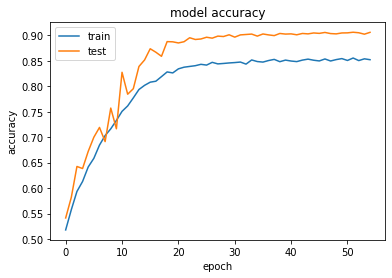

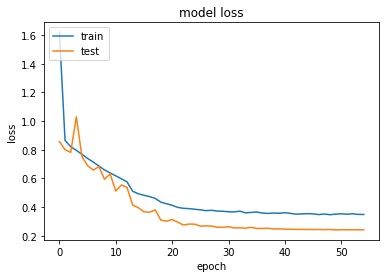

In [39]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [40]:
# Fourth dimension addition in case of its value being onesized
if img_channels == 1:
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
    
predictions = model.predict(X_test, verbose=0)

# Dimension restitution
if img_channels == 1:
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])

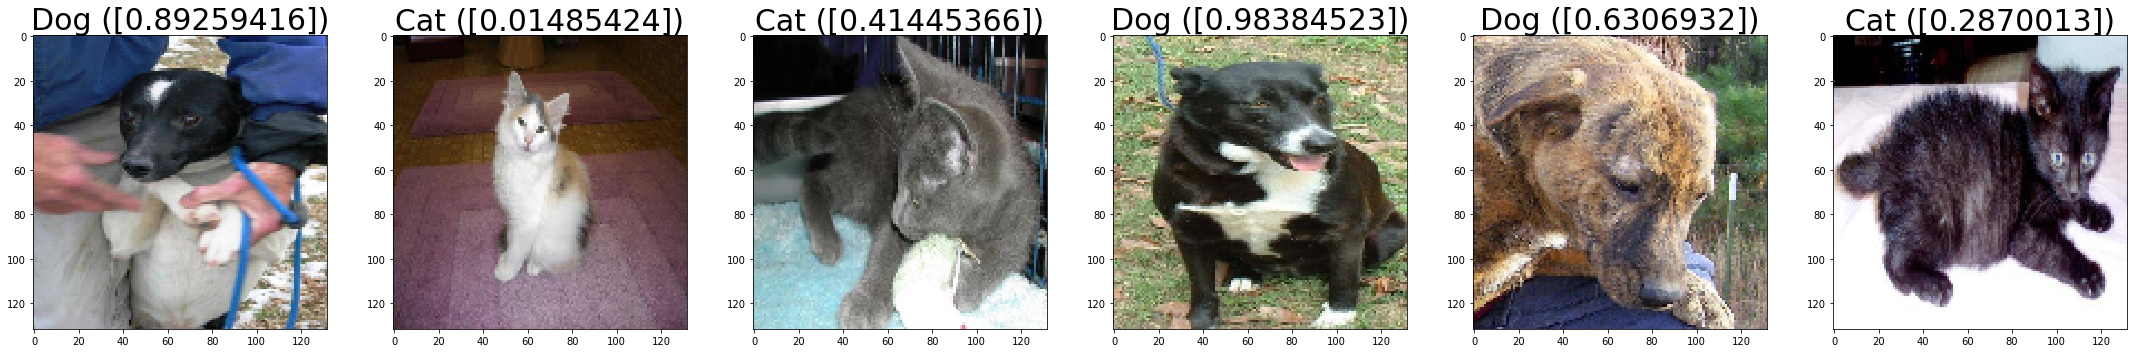

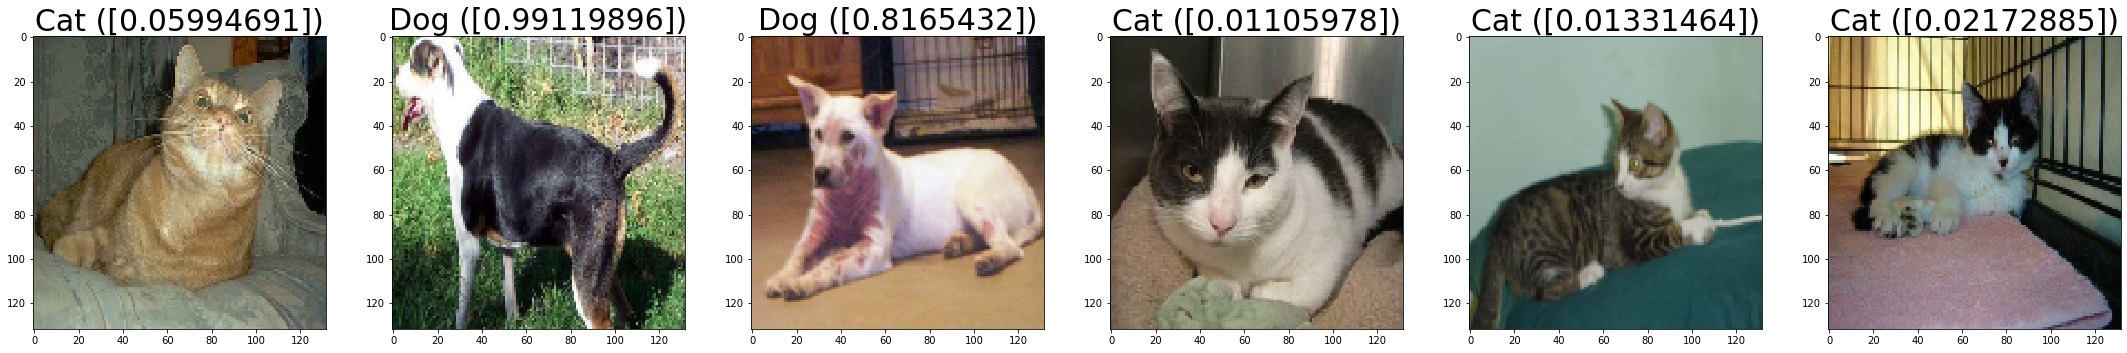

In [41]:
# Preprocess test dataset showcase with predictions
for i in range(0, 10, 6): 
    plot_data(X_test[i:], predictions[i:], 6)

In [42]:
import pandas as pd
# Predictions array must be reshaped into a single dimension array in order to create the dataframe
predictions = predictions.reshape(predictions.shape[0])

if assign_test_labels:
    labels = [1 if pred >= 0.5 else 0 for pred in predictions]
else:
    labels = predictions

submission = pd.DataFrame({'id':test_ids , 'label':labels})
submission.to_csv("submission_3.csv", index=False)
# Let's check what we've got
submission.head()

id     label
0      1  0.892594
1     10  0.014854
2    100  0.414454
3   1000  0.983845
4  10000  0.630693

## Model 4

Model 4 consists of 512 nodes and a convolutions kernel size of 4.

In [43]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(conv_kernel_size, conv_kernel_size), activation='relu', input_shape=(img_width, img_height, img_channels))) # Strides are, by default, (1,1)
add_regularization_layer(model,"batch_normalization")
add_regularization_layer(model,"spatial_dropout", 0.25)
model.add(MaxPooling2D(pool_size=(2,2))) # Strides are, by default, of the same size of the pool size


model.add(Conv2D(64, kernel_size=(conv_kernel_size, conv_kernel_size), activation='relu'))
add_regularization_layer(model,"batch_normalization")
add_regularization_layer(model,"spatial_dropout", 0.25)
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128, kernel_size=(conv_kernel_size, conv_kernel_size), activation='relu'))
add_regularization_layer(model,"batch_normalization")
add_regularization_layer(model,"spatial_dropout", 0.25)
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(256, kernel_size=(conv_kernel_size, conv_kernel_size), activation='relu'))
add_regularization_layer(model,"batch_normalization")
add_regularization_layer(model,"spatial_dropout", 0.25)
model.add(Conv2D(256, kernel_size=(conv_kernel_size, conv_kernel_size), activation='relu'))
add_regularization_layer(model,"batch_normalization")
add_regularization_layer(model,"spatial_dropout", 0.25)
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten()) 

model.add(Dense(512, activation='relu', kernel_regularizer=l2(regularizaion_weight)))
add_regularization_layer(model,"batch_normalization")
add_regularization_layer(model,"dropout", 0.5)
model.add(Dense(512, activation='relu', kernel_regularizer=l2(regularizaion_weight)))
add_regularization_layer(model,"batch_normalization")
add_regularization_layer(model,"dropout", 0.5)
model.add(Dense(num_clases, activation='sigmoid', kernel_regularizer=l2(regularizaion_weight)))

# Stops the training in the case of validation score not improving
if early_stop_overfitting:
    early_stop = EarlyStopping(patience=5)
    
    if not learning_rate_smoothing:
        callbacks = [early_stop]

# Reduces the learning rate of the back propagation gradient descend in the case of validation score not improving
if learning_rate_smoothing:
    learning_rate_reduction = ReduceLROnPlateau(monitor="val_accuracy", patience=2, factor=learning_rate_reduction_factor, min_lr=0.00001, verbose=1)
    
    if not early_stop_overfitting:
        callbacks = [learning_rate_reduction]
    else:
        callbacks = [early_stop, learning_rate_reduction]
        
model.summary()

model.compile(loss='binary_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 129, 129, 32)      1568      
_________________________________________________________________
batch_normalization_21 (Batc (None, 129, 129, 32)      128       
_________________________________________________________________
spatial_dropout2d_15 (Spatia (None, 129, 129, 32)      0         
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 61, 61, 64)        32832     
_________________________________________________________________
batch_normalization_22 (Batc (None, 61, 61, 64)        256       
_________________________________________________________________
spatial_dropout2d_16 (Spatia (None, 61, 61, 64)       

In [44]:
from datetime import datetime
start=datetime.now()

if data_generation:
    
    history = model.fit_generator(data_generator, epochs=epochs, validation_data=val_generator, 
                                  steps_per_epoch=train_size//batch_size, validation_steps=val_size//batch_size, 
                                  callbacks=callbacks, verbose=2)

else:
    
    # Fourth dimension addition in case of its value being onesized
    if img_channels == 1:
        X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
        X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], X_val.shape[2], 1)
        history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val),
                        steps_per_epoch=train_size//batch_size, validation_steps=val_size//batch_size, 
                        callbacks=callbacks, verbose=2)

    # Dimension restitution
    if img_channels == 1:
        X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
        X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], X_val.shape[2])
        
end=datetime.now()
print(end-start)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1250 steps, validate for 312 steps
Epoch 1/100
1250/1250 - 49s - loss: 1.4486 - accuracy: 0.5329 - val_loss: 0.8369 - val_accuracy: 0.5433
Epoch 2/100
1250/1250 - 48s - loss: 0.7729 - accuracy: 0.5975 - val_loss: 0.8278 - val_accuracy: 0.5359
Epoch 3/100
1250/1250 - 48s - loss: 0.7243 - accuracy: 0.6412 - val_loss: 0.6894 - val_accuracy: 0.6691
Epoch 4/100
1250/1250 - 48s - loss: 0.7057 - accuracy: 0.6641 - val_loss: 0.6544 - val_accuracy: 0.6939
Epoch 5/100
1250/1250 - 48s - loss: 0.6849 - accuracy: 0.6763 - val_loss: 0.6288 - val_accuracy: 0.7117
Epoch 6/100
1250/1250 - 48s - loss: 0.6671 - accuracy: 0.6966 - val_loss: 0.6507 - val_accuracy: 0.7011
Epoch 7/100
1250/1250 - 47s - loss: 0.6441 - accuracy: 0.7182 - val_loss: 0.5794 - val_accuracy: 0.7494
Epoch 8/100
1250/1250 - 48s - loss: 0.6187 - accuracy: 0.7323 - val_loss: 0.5523 - val_accuracy: 0.7782
Epoch 9/100
1250/1250 - 48s - loss: 0.6028 - accuracy: 0.7474 - val_loss:

In [45]:
metrics = list(history.history.keys())
loss_values = history.history[metrics[2]]
val_loss_values = history.history[metrics[0]]
acc_values = history.history[metrics[3]]
val_acc_values = history.history[metrics[1]]
print("Final validation loss function is", val_loss_values[-1])
print("Final validation accuracy is", val_acc_values[-1])

Final validation loss function is 0.27870769010186197
Final validation accuracy is 0.8905


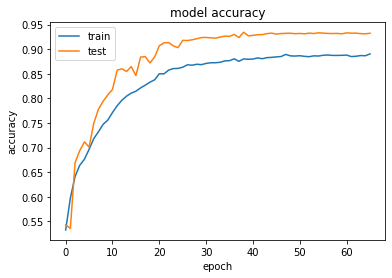

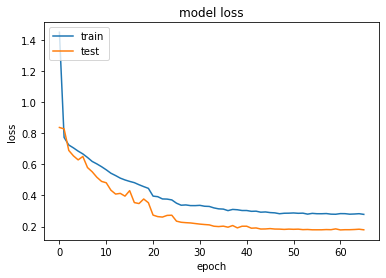

In [46]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [47]:
# Fourth dimension addition in case of its value being onesized
if img_channels == 1:
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
    
predictions = model.predict(X_test, verbose=0)

# Dimension restitution
if img_channels == 1:
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])

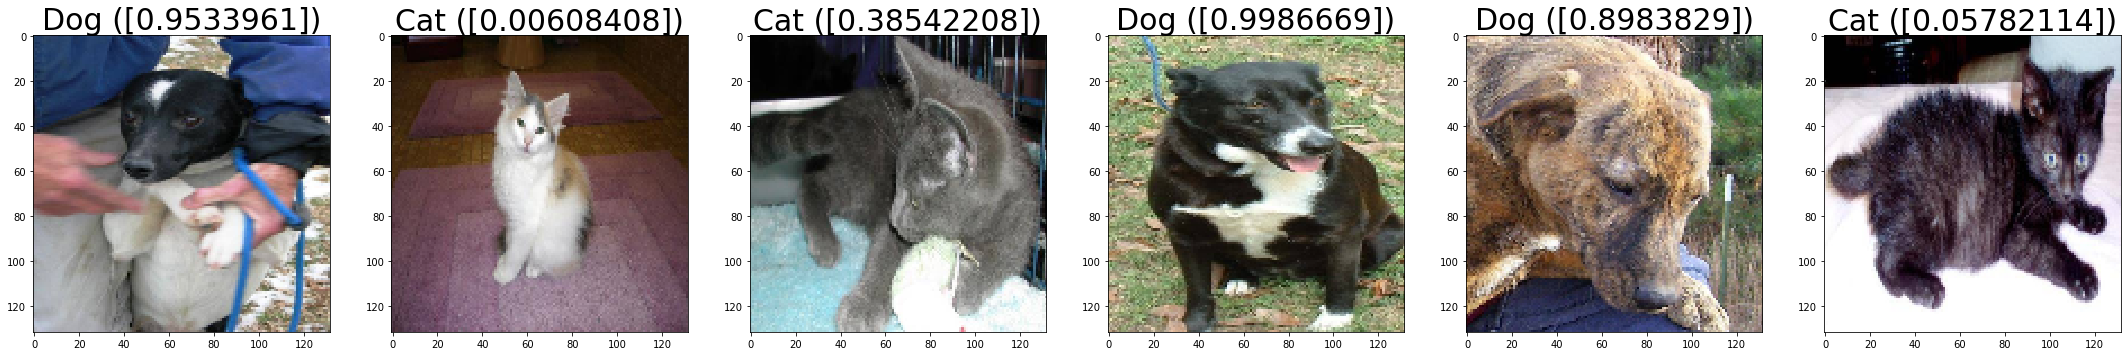

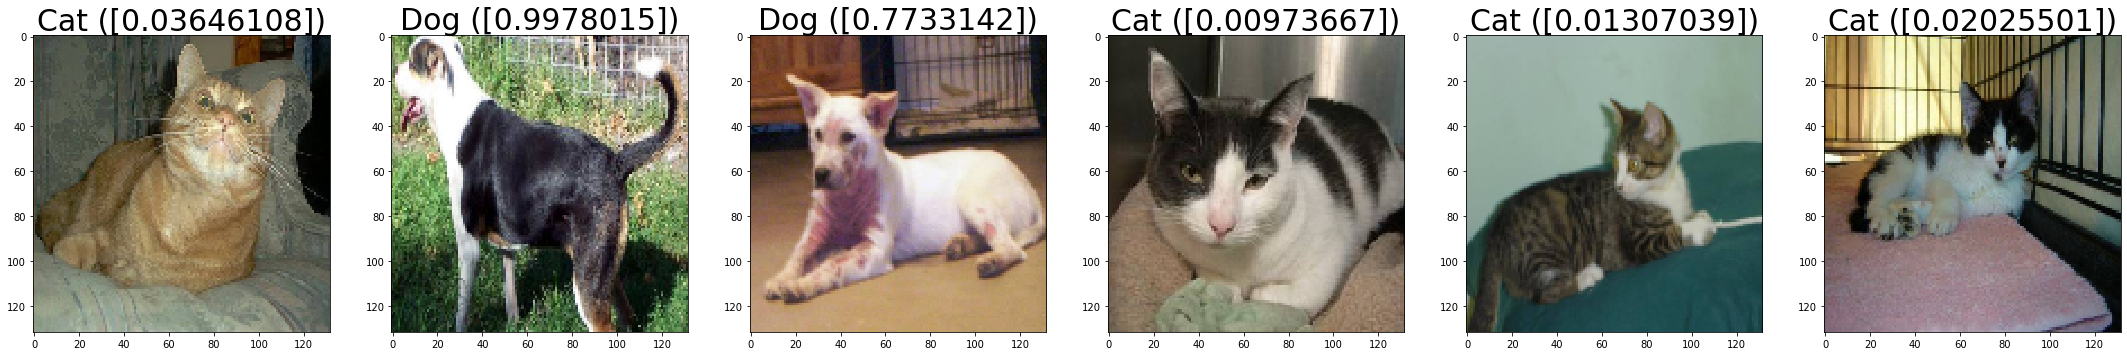

In [48]:
# Preprocess test dataset showcase with predictions
for i in range(0, 10, 6): 
    plot_data(X_test[i:], predictions[i:], 6)

In [49]:
import pandas as pd
# Predictions array must be reshaped into a single dimension array in order to create the dataframe
predictions = predictions.reshape(predictions.shape[0])

if assign_test_labels:
    labels = [1 if pred >= 0.5 else 0 for pred in predictions]
else:
    labels = predictions

submission = pd.DataFrame({'id':test_ids , 'label':labels})
submission.to_csv("submission_4.csv", index=False)
# Let's check what we've got
submission.head()

id     label
0      1  0.953396
1     10  0.006084
2    100  0.385422
3   1000  0.998667
4  10000  0.898383

## Ensemble

In [54]:
pred1 = pd.read_csv("submission_1.csv")
pred2 = pd.read_csv("submission_2.csv")
pred3 = pd.read_csv("submission_3.csv")
pred4 = pd.read_csv("submission_4.csv")


predictions = pd.DataFrame({"id":pred1['id'], 
                             "model1":pred1['label'], 
                             "model2":pred2['label'], 
                             "model3":pred3['label'],
                             "model4":pred4['label']})

predictions['label'] = (predictions['model1'] + predictions['model2'] + predictions['model3'] + predictions['model4'])/4
predictions.head()

id    model1    model2    model3    model4     label
0      1  0.947443  0.963287  0.892594  0.953396  0.939180
1     10  0.012437  0.003383  0.014854  0.006084  0.009190
2    100  0.483709  0.610299  0.414454  0.385422  0.473471
3   1000  0.998116  0.997728  0.983845  0.998667  0.994589
4  10000  0.842741  0.838678  0.630693  0.898383  0.802624

In [55]:
predictions = predictions[['id', 'label']]
predictions.to_csv("submission_ensemble.csv", index=False)

In [56]:
pred1 = pd.read_csv("submission_1.csv")
pred2 = pd.read_csv("submission_2.csv")
pred3 = pd.read_csv("submission_3.csv")
pred4 = pd.read_csv("submission_4.csv")


predictions = pd.DataFrame({"id":pred1['id'], 
                             "model1":pred1['label'], 
                             "model2":pred2['label'], 
                             "model3":pred3['label'],
                             "model4":pred4['label']})

predictions['label'] = ((.4*predictions['model1']) + (.3*predictions['model2']) + (.1*predictions['model3']) + (.2*predictions['model4']))
predictions.head()

id    model1    model2    model3    model4     label
0      1  0.947443  0.963287  0.892594  0.953396  0.947902
1     10  0.012437  0.003383  0.014854  0.006084  0.008692
2    100  0.483709  0.610299  0.414454  0.385422  0.495103
3   1000  0.998116  0.997728  0.983845  0.998667  0.996683
4  10000  0.842741  0.838678  0.630693  0.898383  0.831446

In [57]:
predictions = predictions[['id', 'label']]
predictions.to_csv("submission_ensemble2.csv", index=False)